In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
# from rebin_fk_data import rebin_fk

In [2]:
# from read_fk_table import get_fk_table

import pandas as pd
# import torch
import torch.nn.functional


def get_fk_table(filename):
    """This function reads the fk table for the neutrino flux and pads them for computational efficiency later on

    Returns:
        tuple: x_alphas(grid points) and the fk table in tensor to fit torch
    """


    file_path_n = f"data/{filename}_n.dat"
    df_n = pd.read_csv(file_path_n, sep="\s+", header=None)
    fk_table_n = df_n.to_numpy()

    file_path_p = f"data/{filename}_p.dat"
    df_p = pd.read_csv(file_path_p, sep="\s+", header=None)
    fk_table_p = df_p.to_numpy()

    x_alpha = fk_table_p[0, :]
    x_alpha = x_alpha.reshape(len(x_alpha), 1)

    fk_table = 74 / 183 * fk_table_n + (183 - 74) / 183 * fk_table_p

    # strip first row to get fk table
    fk_table = fk_table[1:, :]

    x_alpha = torch.tensor(x_alpha, dtype=torch.float32).view(-1, 1)
    fk_table = torch.tensor(fk_table, dtype=torch.float32)

    return x_alpha, fk_table
filename = "FK_Enu_mu"
x_alphas, fk_tables_mu = get_fk_table(filename = filename)
filename = "FK_Enu_mub"
x_alphas, fk_tables_mub = get_fk_table(filename = filename)
# xvals_per_obs = [100,300,600,1000,-300,-100]  
# faser_bins = [300, 600, 1000]
# events = [39.5,63.9,54.1,86.3,53.7,24.7]


<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_22977/1165153473.py:17: SyntaxWarning: invalid escape sequence '\s'
  df_n = pd.read_csv(file_path_n, sep="\s+", header=None)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_22977/1165153473.py:21: SyntaxWarning: invalid escape sequence '\s'
  df_p = pd.read_csv(file_path_p, sep="\s+", header=None)


In [13]:
events = [50,97,71,69,48,27]

sig_sys = 0
sig_stat = np.sqrt(events)
binwidths = (100 -20/60) * 65.6/100
xlabels = ['mu']
data = events
def rebin_fk(faser_bins,fk_tables):

    # xvals_per_obs = high[:-1]
    xvals_per_obs = np.linspace(0,6000,100)
    # xvals_per_obs = np.array(xvals_per_obs)
    # data = np.array(data)
    # data_faser,data_faser_min,data_faser_max, = ,[],[],[]
    fk_tables_faser = []
    lower_bound = 100
    for bin_val in faser_bins:
        indices = np.where((xvals_per_obs < bin_val) & (xvals_per_obs > lower_bound))[0]

        print(indices)

        # max_range = max(indices) + min_range + 1

        # data_faser.append(np.sum(data[min_range:max_range]))
        # data_faser_min.append(np.sum(data_min[min_range:max_range]))
        # data_faser_max.append(np.sum(data_max[min_range:max_range]))

        # xvals_per_obs = xvals_per_obs[max(indices)  :]
  
        summed_column = torch.sum(fk_tables[min(indices):max(indices) +1, :], axis=0)
        summed_column = summed_column.unsqueeze(0)
        print(summed_column.shape)
        fk_tables_faser.append(summed_column)

        # min_range = max_range
        lower_bound = bin_val

    # xvals_per_obs_faser.append(xvals_per_obs[-1])    
    # summed_column = torch.sum(fk_tables[max_range:, :], axis=0)
    # summed_column = summed_column.unsqueeze(0)
    # data_faser.append(np.sum(data[max_range:]))
    # data_faser_min.append(np.sum(data_min[max_range:]))
    # data_faser_max.append(np.sum(data_max[max_range:]))
    # fk_tables_faser.append(summed_column)


    fk_tables_faser = torch.cat(fk_tables_faser, dim=0)

    
    # data_faser = np.array(data_faser)
    # data_faser_min = np.array(data_faser_min)
    # data_faser_max = np.array(data_faser_max)


    return fk_tables_faser


# data, data_min, data_max, xvals_per_obs, binwidths, xlabels, events_per_obs = rebin_fk()
faser_bins_mu = [300, 600, 1000,1900]
fk_table_mu = rebin_fk(faser_bins_mu,fk_tables_mu)
faser_bins_mub = [300, 1000,1900]
fk_table_mub = rebin_fk(faser_bins_mub,fk_tables_mub)
# xvals_per_obs = [100,300,600,1000,-300,-100]
# xvals_per_obs = [100,300,600,1000,-300,-100]
xvals_per_obs_mu = [100,300,600,1000]
xvals_per_obs = [100,300,600,1000,-300,-100]

[2 3 4]
torch.Size([1, 50])
[5 6 7 8 9]
torch.Size([1, 50])
[10 11 12 13 14 15 16]
torch.Size([1, 50])
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
torch.Size([1, 50])
[2 3 4]
torch.Size([1, 50])
[ 5  6  7  8  9 10 11 12 13 14 15 16]
torch.Size([1, 50])
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
torch.Size([1, 50])


LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_22977/4087063270.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


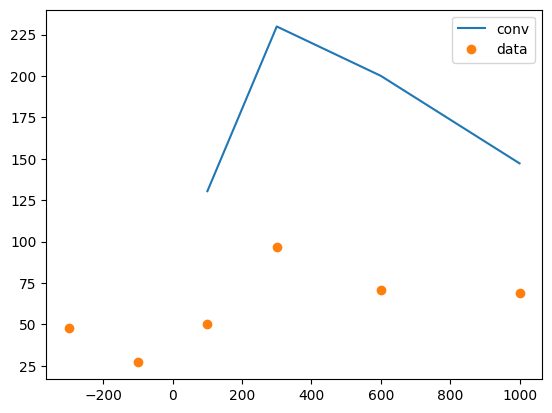

In [17]:
pdf = "faserv"
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_table_mu,faser_pdf) * binwidths 
plt.plot(xvals_per_obs_mu,conv,label='conv')
plt.plot(xvals_per_obs,data,'o',label='data')
plt.legend()

In [18]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 3

#HYPERPARAMETERS
preproc = 1
l1 = 6
l2 = 8
l3 = 6
# l1 = 20
# l2 = 40
# l3 = 20

fit_level = 0
# lr = 1e-3
lr = 0.03
print(lr)
max_counter = 50
max_Nepochs = 3500

0.03


In [19]:
# data,data_min,data_max,xvals_per_obs,binwidths,xlabels,events_per_obs,fk_tables,x_alphas = rebin_fk(rebin=1)

In [24]:
#Get errors
# sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max)  
# xvals_per_obs = [100,300,600,-100,-300,1000] 
# xvals_per_obs = [100,300,600,100,-300,-100]  
cov_matrix = np.array([
    [9.2,-0.32,  0.08, -0.03,  0.00,  0.00],
    [-0.32, 10.2, -0.43,  0.10, -0.01, -0.00],
    [ 0.08, -0.43, 9.6, -0.31,  0.04, -0.02],
    [-0.03,  0.10, -0.31, 22.3,-0.14,  0.01],
    [ 0.00, -0.01,  0.04, -0.14, 12.1,-0.24],
    [ 0.00, -0.00, -0.02,  0.01, -0.24,7.5]
])

np.fill_diagonal(cov_matrix, sig_stat**2)
cov_matrix = np.linalg.inv(cov_matrix)
cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32, requires_grad=False)
#Generate MC replicas of data
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals,14)

0
[7.07106781 9.8488578  8.42614977 8.30662386 6.92820323 5.19615242]
1
[-0. -0.  0.  0.  0.  0.] [ 1.24789757 -4.17557506  9.35375254 12.52981601  4.50007928  6.26010766]
2
[ 0.  0.  0. -0. -0. -0.] [-2.36884399 -9.29839098 -4.33145334 -0.05334239  9.89891426  1.37432691]
1
[ 0. -0.  0. -0. -0.  0.] [ 4.3341576  -6.60296497  5.29221612  0.6661086   0.39771699 -0.372486  ]
2
[0. 0. 0. 0. 0. 0.] [ 3.01198975  8.48187615  3.27684729 -2.73517102  5.9485612   4.00670061]
1
[ 0. -0.  0. -0.  0.  0.] [-5.30914917 12.91207333  3.67235753 -0.25243589  6.29285004  4.47102653]
2
[ 0. -0.  0. -0.  0. -0.] [ -2.75617073 -13.09103304   5.21994108   2.4284539    3.07590641
   4.36677963]
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [25]:
print(data)
# print(data_max)
# print(data_min)

[50, 97, 71, 69, 48, 27]


In [26]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

[50, 97, 71, 69, 48, 27]
[tensor([51.2479, 92.8244, 80.3538, 81.5298, 52.5001, 33.2601]), tensor([54.3342, 90.3970, 76.2922, 69.6661, 48.3977, 26.6275]), tensor([ 44.6908, 109.9121,  74.6724,  68.7476,  54.2929,  31.4710])]
[tensor([48.8791, 83.5260, 76.0223, 81.4765, 62.3990, 34.6344]), tensor([57.3461, 98.8789, 79.5691, 66.9309, 54.3463, 30.6342]), tensor([41.9347, 96.8210, 79.8923, 71.1760, 57.3688, 35.8378])]


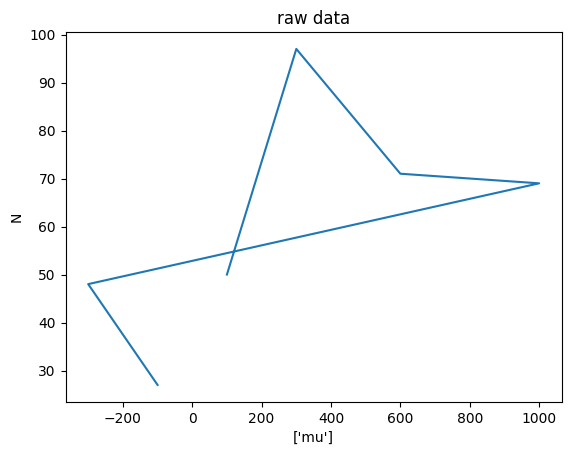

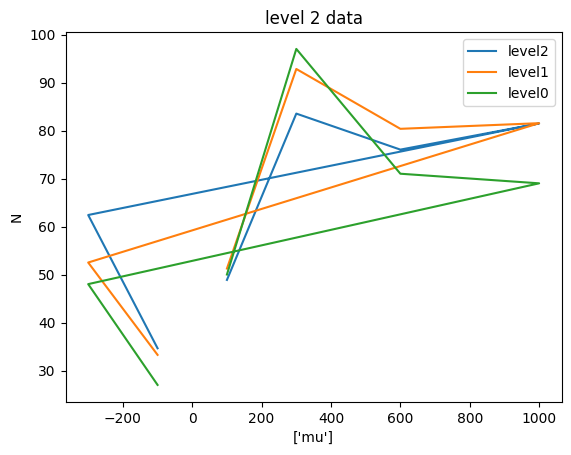

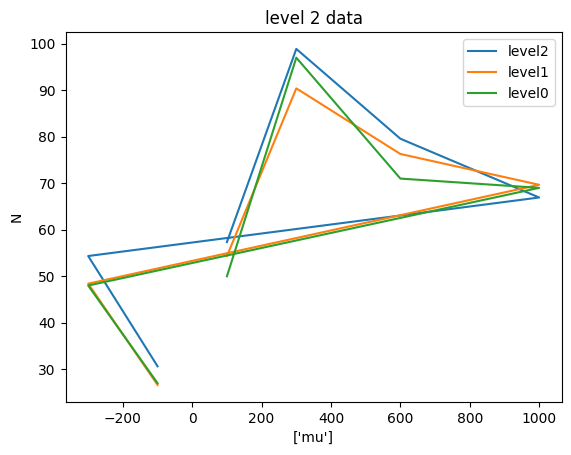

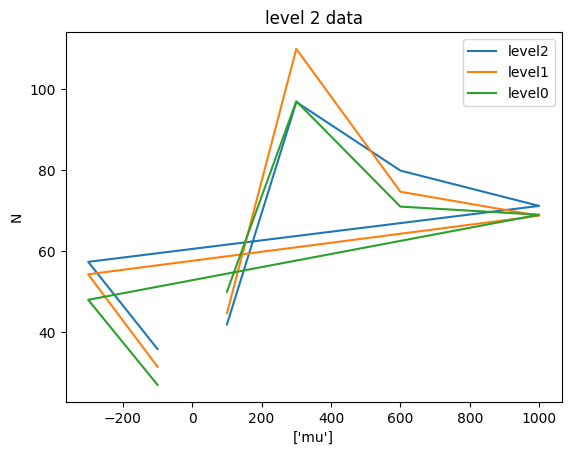

In [27]:
print(data)
print(level1)
print(level2)
plt.plot(xvals_per_obs,data)
plt.xlabel(xlabels)
plt.ylabel('N')
plt.title("raw data")
plt.show()

for i in range(REPLICAS):
    plt.plot(
        xvals_per_obs, level2[i], label="level2"
    )
    plt.plot(
        xvals_per_obs, level1[i], label="level1"
    )
    plt.plot(xvals_per_obs, data,label="level0")
    plt.xlabel(xlabels)
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()


In [28]:
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,2)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
        # y = self.relu(y)
        # y = torch.nn.functional.softplus(y)
    
        return y

In [29]:
import torch.nn as nn

if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))
            # self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=False ))
            # self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=False ))
            # self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=False))

        def forward(self, x):
            # return self.gamma*(1 - x) ** abs(self.beta) * x ** (1-self.alpha)
            # alpha = (0.8*torch.tanh(self.alpha))
            # alpha = (1.6 - 0.2)/2 *torch.tanh(self.alpha) + (1.6 + 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = abs(self.beta)
            # return self.gamma * (1 - x) ** beta * x**(1-alpha) 
            return  self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            return f_nu
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [30]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix)
        return loss

In [31]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
neutrino_pdfs,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[]

In [32]:
def perform_fit(pred,REPLICAS):
    for i in range(REPLICAS):
        losses = []
        if preproc == 1:
            alpha,beta,gamma = 1,1,10
            model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)
            # model.load_state_dict(model_params)    

        criterion = CustomLoss()
        # criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        pred[i] = pred[i].squeeze()
        model.train()
        best_loss = 1e13 # initial loss
        counter = 0
        num_epochs = 2000
        for ep in range(num_epochs):
        # while counter < max_counter:  
        #     if num_epochs>max_Nepochs:
        #         break
            
            # num_epochs+=1
            optimizer.zero_grad()
            y_pred =  model(x_alphas) * x_alphas
            y_pred_mu = torch.matmul(fk_table_mu,y_pred[:,0])  * binwidths 
            y_pred_mub = torch.matmul(fk_table_mub,y_pred[:,1])  * binwidths 

            y_pred_mu = y_pred_mu.squeeze()
            y_pred_mub = y_pred_mub.squeeze()

            y_pred_mu[-1] = y_pred_mu[-1] + y_pred_mub[-1]
            
            y_pred_mub = y_pred_mub[:-1]
            # y_pred_mub = y_pred_mub[::-1]
            y_pred_mub = torch.flip(y_pred_mub, dims=[0])
            
            y_preds = torch.hstack((y_pred_mu, y_pred_mub))

            loss = criterion(y_preds, pred[i],cov_matrix)
            loss.backward()
            print(loss)
    
            losses.append(loss.detach().numpy())
            optimizer.step()
            
            # if ep % 100 == 0:

            #     print(loss.detach().numpy())   
            if loss <.00001:
                break
            # if loss < best_loss:
            #     best_loss = loss
            #     counter = 0
            # else:
            #     counter +=1   

        if loss < 100:    
            print(num_epochs) 
        
            # loss, pos_penalty, int_penalty = criterion(y_preds, pred[i],cov_matrix, positivity,lag_mult_pos, integrability,x_integrability, y_integrability)
            # red_chi_square_level1,*_ = criterion(y_preds, level1[0],cov_matrix, positivity,lag_mult_pos, integrability,x_integrability, y_integrability)

            print(f"reduced chi^2 level 2 = {loss}")
            # print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
            print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            print(f"Constrained beta: {(model.preprocessing.beta.item())}")
            # print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 

            # print('max_alpha,min_alpha,max_beta,min_beta')
            # print(compute_effective_coeff(model))

            # save outcome of fit and its measures for postfit selection criteria
            closure_fit = Postfit()
            # arc_lenghts.append(closure_fit.compute_arc_length(model))
            chi_squares.append(loss.detach().numpy())
            # preproc_pdf = ((1 - x_alpha_more_bins) ** (beta) * x_alpha_more_bins ** (1-alpha)).detach().numpy().flatten()
            f_nu = model(x_vals)[:,0].detach().numpy().flatten() 
            # print(preproc_pdf.shape)
            print(f_nu.shape)
            preproc_pdf = model.preproc(x_vals).detach().numpy().flatten()
            preproc_pdfs.append(model.preproc(x_vals).detach().numpy().flatten())
            nn_pdfs.append(model.neuralnet(x_vals)[:,0].detach().numpy().flatten())
            # pos_penaltys.append(pos_penalty.detach().numpy())
            # int_penaltys.append(np.sqrt(int_penalty.detach().numpy()))
            N_event_pred.append(y_preds.detach().numpy())
            # cont_pred = model(x_alpha_more_bins).detach().numpy().flatten()
            neutrino_pdfs.append(f_nu)
            # plt.yscale('log')
            print(f'counter = {counter}')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
            # plt.plot(x_alpha_more_bins,preproc_pdf)
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
    # return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model
    return chi_squares,N_event_pred, neutrino_pdfs,model

tensor(60.8213, grad_fn=<MulBackward0>)
tensor(60.6806, grad_fn=<MulBackward0>)
tensor(60.5338, grad_fn=<MulBackward0>)
tensor(60.3623, grad_fn=<MulBackward0>)
tensor(60.1729, grad_fn=<MulBackward0>)
tensor(59.9347, grad_fn=<MulBackward0>)
tensor(59.6338, grad_fn=<MulBackward0>)
tensor(59.2538, grad_fn=<MulBackward0>)
tensor(58.7790, grad_fn=<MulBackward0>)
tensor(58.1913, grad_fn=<MulBackward0>)
tensor(57.4702, grad_fn=<MulBackward0>)
tensor(56.5939, grad_fn=<MulBackward0>)
tensor(55.5408, grad_fn=<MulBackward0>)
tensor(54.2919, grad_fn=<MulBackward0>)
tensor(52.8357, grad_fn=<MulBackward0>)
tensor(51.1760, grad_fn=<MulBackward0>)
tensor(49.3455, grad_fn=<MulBackward0>)
tensor(47.4276, grad_fn=<MulBackward0>)
tensor(45.5927, grad_fn=<MulBackward0>)
tensor(44.1506, grad_fn=<MulBackward0>)
tensor(43.5945, grad_fn=<MulBackward0>)
tensor(44.3953, grad_fn=<MulBackward0>)
tensor(45.9510, grad_fn=<MulBackward0>)
tensor(46.6303, grad_fn=<MulBackward0>)
tensor(46.1242, grad_fn=<MulBackward0>)


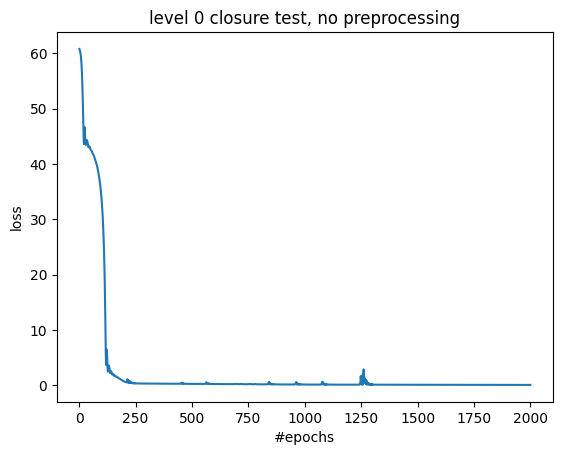

tensor(60.7005, grad_fn=<MulBackward0>)
tensor(60.5922, grad_fn=<MulBackward0>)
tensor(60.4641, grad_fn=<MulBackward0>)
tensor(60.3095, grad_fn=<MulBackward0>)
tensor(60.1236, grad_fn=<MulBackward0>)
tensor(59.9023, grad_fn=<MulBackward0>)
tensor(59.6297, grad_fn=<MulBackward0>)
tensor(59.2901, grad_fn=<MulBackward0>)
tensor(58.8664, grad_fn=<MulBackward0>)
tensor(58.3373, grad_fn=<MulBackward0>)
tensor(57.6791, grad_fn=<MulBackward0>)
tensor(56.8668, grad_fn=<MulBackward0>)
tensor(55.8747, grad_fn=<MulBackward0>)
tensor(54.6785, grad_fn=<MulBackward0>)
tensor(53.2593, grad_fn=<MulBackward0>)
tensor(51.6108, grad_fn=<MulBackward0>)
tensor(49.7525, grad_fn=<MulBackward0>)
tensor(47.7518, grad_fn=<MulBackward0>)
tensor(45.7613, grad_fn=<MulBackward0>)
tensor(44.0796, grad_fn=<MulBackward0>)
tensor(43.2227, grad_fn=<MulBackward0>)
tensor(43.8133, grad_fn=<MulBackward0>)
tensor(45.4820, grad_fn=<MulBackward0>)
tensor(46.3440, grad_fn=<MulBackward0>)
tensor(45.8672, grad_fn=<MulBackward0>)


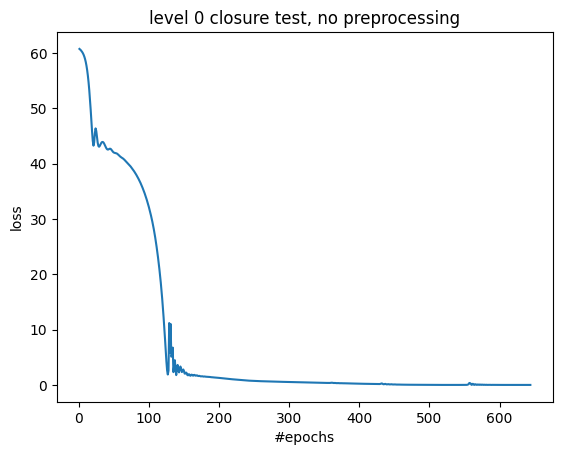

tensor(60.6866, grad_fn=<MulBackward0>)
tensor(60.6504, grad_fn=<MulBackward0>)
tensor(60.6113, grad_fn=<MulBackward0>)
tensor(60.5676, grad_fn=<MulBackward0>)
tensor(60.5224, grad_fn=<MulBackward0>)
tensor(60.4650, grad_fn=<MulBackward0>)
tensor(60.4048, grad_fn=<MulBackward0>)
tensor(60.3380, grad_fn=<MulBackward0>)
tensor(60.2637, grad_fn=<MulBackward0>)
tensor(60.1812, grad_fn=<MulBackward0>)
tensor(60.0894, grad_fn=<MulBackward0>)
tensor(59.9873, grad_fn=<MulBackward0>)
tensor(59.8738, grad_fn=<MulBackward0>)
tensor(59.7475, grad_fn=<MulBackward0>)
tensor(59.6071, grad_fn=<MulBackward0>)
tensor(59.4507, grad_fn=<MulBackward0>)
tensor(59.2768, grad_fn=<MulBackward0>)
tensor(59.0832, grad_fn=<MulBackward0>)
tensor(58.8676, grad_fn=<MulBackward0>)
tensor(58.6277, grad_fn=<MulBackward0>)
tensor(58.3607, grad_fn=<MulBackward0>)
tensor(58.0635, grad_fn=<MulBackward0>)
tensor(57.7329, grad_fn=<MulBackward0>)
tensor(57.3653, grad_fn=<MulBackward0>)
tensor(56.9567, grad_fn=<MulBackward0>)


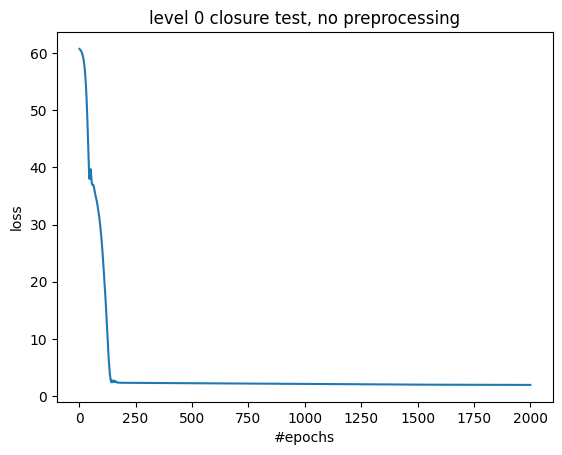

In [33]:
chi_squares,N_event_pred, neutrino_pdfs,model = perform_fit(pred,REPLICAS)

In [34]:
closure_fit = Postfit()
neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(chi_squares,N_event_pred,neutrino_pdfs)

0.6410364 0.92537355
0.6675499 0.92537355
1.3085864 0.92537355


In [35]:
x_vals = x_vals.detach().numpy().flatten()
faser_pdf,x_faser = read_pdf(pdf,x_vals,14) 
mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [36]:
# from lhapdf_grid import write_lhapdf_grid
# mean_fnu = np.mean(neutrino_pdfs, axis=0) * x_vals
# lhapdfpath = '/opt/anaconda3/envs/nnpdf_dev/share/LHAPDF/enu/enu_0000.dat'

# write_lhapdf_grid(x_vals,mean_fnu,lhapdfpath)

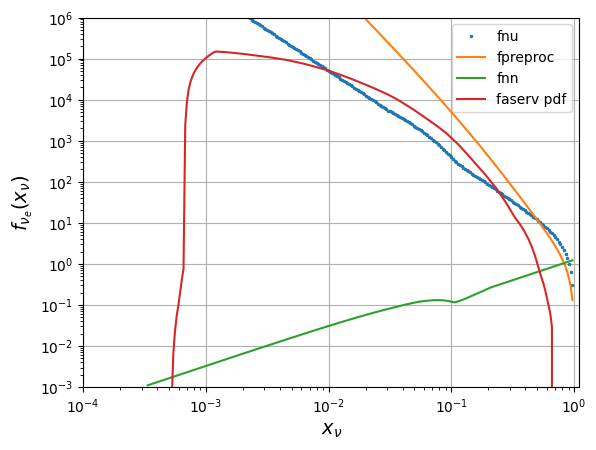

In [37]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals,mean_fnu,'o',label="fnu",markersize=1.5)
plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
plt.plot(x_vals,mean_nn_pdf*x_vals,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
plt.ylim(10**-3,10**6)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

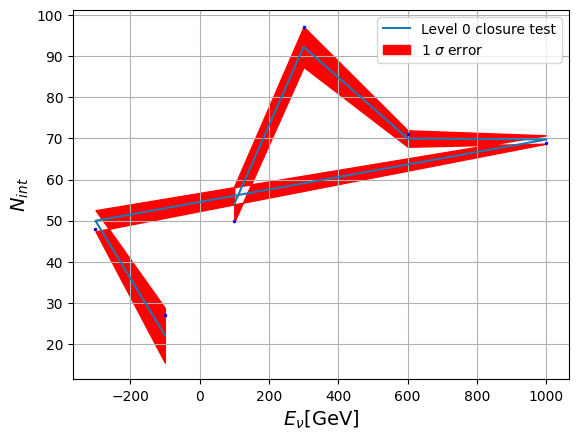

In [38]:
mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
plt.plot(xvals_per_obs,mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(xvals_per_obs,(mean_N_event_fit+sigma_N_event_fit),(mean_N_event_fit-sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(xvals_per_obs,level0[0],'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [21]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo